<a href="https://colab.research.google.com/github/Sunshines01/Sunshines01/blob/main/CMS_MMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question 1:

- Analyse correlation between foetal Y-chromosome concentration and factors such as gestational age and maternal BMI (which are thought to be related to Y-chromosome)
- propose model to test statistical significance

extract data:

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pingouin as pg

if not os.path.exists("/content/Dataset.xlsx"):
    raise FileNotFoundError("Dataset.xlsx not found")

data = pd.read_excel("/content/Dataset.xlsx")
data_NIPT = data.values

def parse_gestational_age(ga):
    """
    Parse gestational age in formats like:
      '24w+3'  → 24 weeks, 3 days
      '24w'    → 24 weeks, 0 days
      '24'     → not accepted (no 'w')
    Returns total weeks as float, or np.nan if invalid.
    """
    if pd.isna(ga) or str(ga).strip() == '':
        return np.nan

    s = str(ga).strip()
    match = re.search(r'^(\d+)\s*[wW]\s*(?:\+\s*(\d+))?\s*$', s)

    if not match:
        return np.nan

    try:
        weeks = int(match.group(1))
        days_str = match.group(2)
        days = int(days_str) if days_str is not None else 0

        # Validate days (must be 0–6)
        if days < 0 or days >= 7:
            return np.nan

        total_days = weeks * 7 + days
        total_weeks = total_days / 7.0
        return total_weeks

    except (ValueError, TypeError):
        return np.nan

Y_chromosome = pd.to_numeric(data.iloc[:, 21], errors='coerce')
mat_bmi = pd.to_numeric(data.iloc[:, 10], errors='coerce')
gest_age = data.iloc[:, 9].apply(parse_gestational_age)
preg_id = data.iloc[:,1]

#analyse correlation between Y-chromosome with gest_age and mat_bmi
#model to test statistical significance

df = pd.DataFrame({
    'preg_id': preg_id,
    'Y_chromosome': Y_chromosome,
    'gest_age': gest_age,
    'mat_bmi': mat_bmi
}).dropna()


Testing uniqueness of data - as shown below we find that there is a lot of overlap in data points so data is not linear. Any linear models will not work here

In [ ]:
print("Unique values in Y_chromosome:")
print(len(df['Y_chromosome'].unique()))

print("Unique values in gest_age:")
print(len(df['gest_age'].unique()))

print("Unique values in mat_bmi:")
print(len(df['mat_bmi'].unique()))

Unique values in Y_chromosome:
1082
Unique values in gest_age:
100
Unique values in mat_bmi:
783


Plotting data on a graph for visualisation

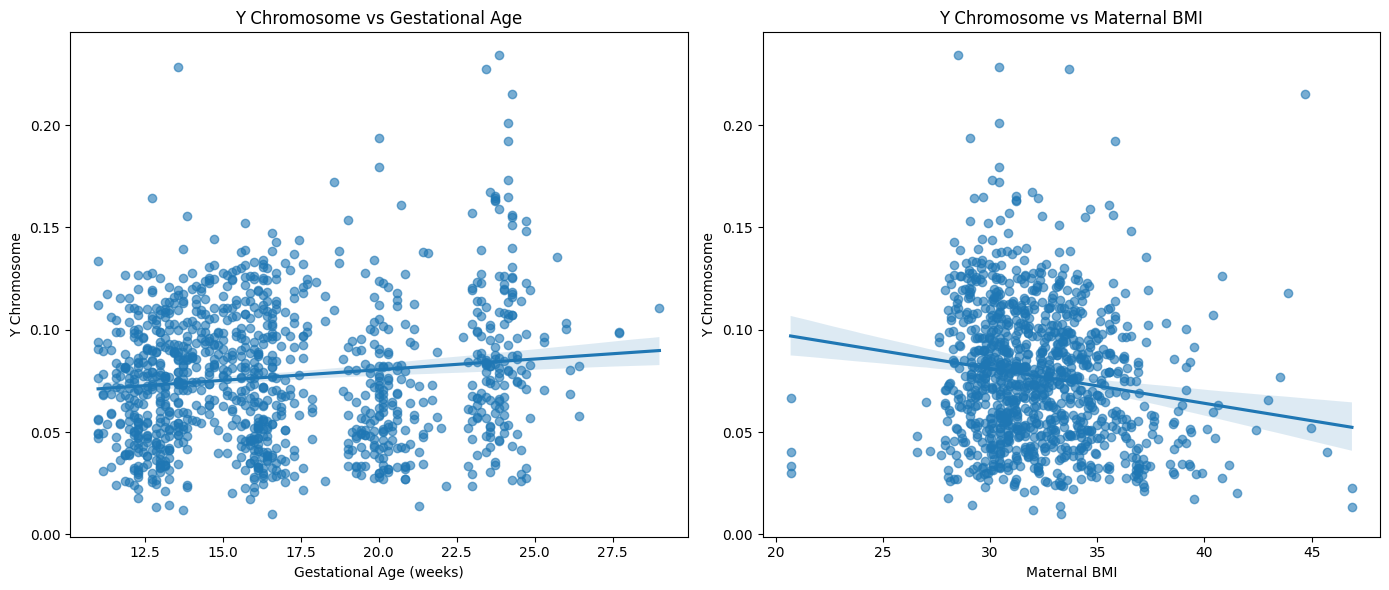

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Y vs Gestational Age
sns.regplot(x='gest_age', y='Y_chromosome', data=df, ax=axes[0], scatter_kws={'alpha':0.6})
axes[0].set_title('Y Chromosome vs Gestational Age')
axes[0].set_xlabel('Gestational Age (weeks)')
axes[0].set_ylabel('Y Chromosome')

# Y vs Maternal BMI
sns.regplot(x='mat_bmi', y='Y_chromosome', data=df, ax=axes[1], scatter_kws={'alpha':0.6})
axes[1].set_title('Y Chromosome vs Maternal BMI')
axes[1].set_xlabel('Maternal BMI')
axes[1].set_ylabel('Y Chromosome')

plt.tight_layout()
plt.show()

Pearson correlation measures strength of linear relationship between two continuous variables, spearman-rank measures stength of monotomic relationship:

In [ ]:
r_gest, p_gest = st.pearsonr(df['Y_chromosome'], df['gest_age'])
r_bmi, p_bmi = st.pearsonr(df['Y_chromosome'], df['mat_bmi'])

print(f"Gest Age: r = {r_gest:.3f}, p = {p_gest}")
print(f"Mat BMI:  r = {r_bmi:.3f}, p = {p_bmi}")


rho_gest, p_gest = st.spearmanr(df['Y_chromosome'], df['gest_age'])
rho_bmi, p_bmi = st.spearmanr(df['Y_chromosome'], df['mat_bmi'])

print(f"Spearman: Y vs Gest Age - rho = {rho_gest:.3f}, p = {p_gest:.2e}")
print(f"Spearman: Y vs Mat BMI  - rho = {rho_bmi:.3f}, p = {p_bmi:.2e}")


Gest Age: r = 0.127, p = 2.9795639953541563e-05
Mat BMI:  r = -0.151, p = 5.736662841941697e-07
Spearman: Y vs Gest Age - rho = 0.084, p = 5.53e-03
Spearman: Y vs Mat BMI  - rho = -0.155, p = 3.02e-07


Pearson correlation suggests linear correlation between the variables, spearman-rank suggests weak positive monotonic association for gestational age, weak negative monotonic association for maternal BMI

Suggests maternal BMI has a more reliable inverse relationship with Y-chromosome than gestational age does.

Significance of p-value through permutation test:

In [ ]:
def permutation_test(x, y, n_perm=10000, stat='pearson'):
    x = np.asarray(x)
    y = np.asarray(y)

    # Observed statistic
    if stat == 'pearson':
        real_stat, _ = st.pearsonr(x, y)
    elif stat == 'spearman':
        from scipy.stats import spearmanr
        real_stat, _ = st.spearmanr(x, y)
    else:
        raise ValueError("stat must be 'pearson' or 'spearman'")

    null_stats = []
    for _ in range(n_perm):
        y_perm = np.random.permutation(y)
        if stat == 'pearson':
            r, _ = st.pearsonr(x, y_perm)
        else:
            r, _ = st.spearmanr(x, y_perm)
        null_stats.append(r)

    null_stats = np.array(null_stats)
    p_value = (np.abs(null_stats) >= np.abs(real_stat)).mean()
    return real_stat, p_value, null_stats

# Run tests
y = df['Y_chromosome']
x1 = df['gest_age']
x2 = df['mat_bmi']

# Gestational Age
r1, p1, null1 = permutation_test(x1, y, n_perm=10000, stat='pearson')
print(f"Permutation test (Gestation Age): r = {r1:.3f}, p = {p1}")

# Maternal BMI
r2, p2, null2 = permutation_test(x2, y, n_perm=10000, stat='pearson')
print(f"Permutation test (Maternal BMI): r = {r2:.3f}, p = {p2}")

Permutation test (Gest Age): r = 0.127, p = 0.0001
Permutation test (Mat BMI): r = -0.151, p = 0.0


10000 iterations of permutation tests show that Y-chromosome fraction increased with gestational age and decreased with maternal BMI.

The permutation test makes no assumptions about normality, linearity or distribution.

Maternal BMI has a more extreme correlation than gestational age.

95% confidence interval for spearman-rank test:

In [ ]:
result = pg.corr(df['Y_chromosome'], df['gest_age'], method='pearson')
print(result[['r', 'CI95%']])

               r         CI95%
pearson  0.12656  [0.07, 0.18]


Shows weak positive linear association
Correlation is statistically significant


Reference: https://www.datacamp.com/tutorial/linear-regression-in-python
Multiple linear regression model:

In [ ]:
y = df['Y_chromosome'].values
X = df[['gest_age', 'mat_bmi']].values

X = np.column_stack((np.ones(X.shape[0]), X))

beta = np.linalg.inv(X.T @ X) @ X.T @ y
print("Coefficients:", beta)

n = len(y)
residuals = y - (X @ beta)
mse = np.mean(residuals**2)
se = np.sqrt(mse * np.diag(np.linalg.inv(X.T @ X)))
t = beta / se
p = 2 * (1 - st.t.cdf(np.abs(t), n - len(beta)))

print(f"p-value = {p}")

ss_res = np.sum(residuals**2)          # Residual sum of squares
ss_tot = np.sum((y - np.mean(y))**2)   # Total sum of squares
r_squared = 1 - (ss_res / ss_tot)      # R²

print(f"R^2 = {r_squared}")

Coefficients: [ 0.11946111  0.00125539 -0.00196421]
p-value = [0.0000000e+00 4.3842300e-07 8.7594314e-09]
R^2 = 0.04567681267376644


Maternal BMI has a stronger effect than gestational age.


Y chromosome fraction iss positively associated with gestational age and negatively associated with maternal BMI, after mutual adjustment. The model explained approximately 4.5% of the variance in Y chromosome.

Linear regression should not really be the way forward here though. Although there is proven linear association, we also know that some women contributed multiple samples, which makes the linear regression model here incorrect.

Mixed linear model regression: https://www.geeksforgeeks.org/machine-learning/introduction-to-linear-mixed-effects-models/#implementing-linear-mixedeffects-models-in-python

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm


full_model = mixedlm(
    "Y_chromosome ~ gest_age + mat_bmi",
    data=df,
    groups=df["preg_id"]
).fit()

print(full_model.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y_chromosome
No. Observations: 1082    Method:             REML        
No. Groups:       267     Scale:              0.0003      
Min. group size:  1       Log-Likelihood:     2514.7132   
Max. group size:  8       Converged:          Yes         
Mean group size:  4.1                                     
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    0.070     0.016   4.312  0.000   0.038   0.101
gest_age     0.003     0.000  19.432  0.000   0.003   0.003
mat_bmi     -0.001     0.001  -2.649  0.008  -0.002  -0.000
Group Var    0.001     0.005                               



/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Question 2

- Maternal BMI = primary factor affecting earliest time at which Y-chromosome concentration of male foetuses >= 4%

- Group male foetuses according to BMI
- Specify BMI interval and optimal NIPT timing for each group to minimise maternal risk
- Analyse impact of measurement error on results